In [66]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings
from lib.merge import prepare_train_show

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [67]:
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = sys.executable

spark = SparkSession.builder.appName("renovation").getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [68]:
# import files
# File location and type
file_location_array = [
    {
        "location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full",
        "delimiter": ",",
    },
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"},
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [69]:
# name the important datasets and cast to type
training_tremi = dataframes["pred_tremi_full"].withColumns(
    {
        "surface": F.col("surface").cast("int"),
        "heating_production": F.col("heating_production").cast("int"),
    }
)

dictionary = dataframes["dictionary"]

In [70]:
# split training and prediction datasets
training_surf = training_tremi.filter(F.col("surface").isNotNull()).drop(
    "heating_production"
)
predicting_surf = training_tremi.filter(F.col("surface").isNull()).drop(
    "heating_production"
)

training_prod = training_tremi.filter(F.col("heating_production").isNotNull()).drop(
    "surface"
)
predicting_prod = training_tremi.filter(F.col("heating_production").isNull()).drop(
    "surface"
)

print(
    f"""
{training_surf.count() =}
{predicting_surf.count() =}\n
{training_prod.count() =}
{predicting_prod.count() =}\n
"""
)


training_surf.count() =12565
predicting_surf.count() =26933

training_prod.count() =11128
predicting_prod.count() =28370




In [76]:
from imblearn.over_sampling import SMOTE

# librairies
import numpy as np
import matplotlib.pyplot as plt

# usefull
from copy import deepcopy

# prepare data
from sklearn.model_selection import train_test_split
from lib.prepare_data import prepare_dataset
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

# scoring and training
from sklearn.metrics import f1_score
from lib.train import train_hyper, choose_params, nb_possibility, iterate_params
from sklearn.model_selection import cross_val_score

# logisitc
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBClassifier

# hyperparams
from scipy.stats import uniform, randint

# insights
from lib.show import show_matrix

In [72]:
# parameters of optimized models
lr_param = {'C': 6.522117123602399, 'class_weight': 'balanced', 'max_iter': 1000}
RF_param = {"class_weight": "balanced", "max_depth": 19, "n_estimators": 171}
balanced_params = {"class_weight": "balanced", "max_depth": 23, "n_estimators": 174}

In [73]:
training_prod = training_prod.withColumn('index', F.monotonically_increasing_id())

In [77]:
# global parameters
col_X_hot = [["occupation", "nb_persons_home", "income", "department_number"], []]
col_y = ["heating_production"]
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y + ['index']]
    for i in range(len(col_X_hot))
]

#prepare each datasets
X, y, _ = prepare_dataset(
    training_prod.drop('index'), dictionary, col_X_hot[1], col_X_not_hot[1], col_y, False, True
)

indexes_train = np.random.choice(X.shape[0], int(X.shape[0]*0.85), replace=False)
X_train = X[indexes_train, :]
y_train = y[indexes_train]
valid_index = [i for i in range(X.shape[0]) if i not in indexes_train]
X_valid = X[valid_index, :]
y_valid = y[valid_index]

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.175, random_state=42
)

RF = RandomForestClassifier(**RF_param).fit(X_train, y_train)
LR = LogisticRegression(**lr_param).fit(X_train, y_train)
y_pred = RF.predict(X_valid)

split = ShuffleSplit(4, test_size=0.4, random_state=42)

# smote params
param_sample = {
    "random_state": [42],
    "sampling_strategy": [
        {5: 3120, 0: 3120, 1: 3000, 2: 2700, 4: 2500, 3: 2000},
        {5: 3916, 0: 3407, 1: 3000, 2: 2700, 4: 2500, 3: 2000},
        {5: 3120, 0: 3120, 1: 3120, 2: 3120, 4: 3120, 3: 3120},
        {5: 3120, 0: 3120, 1: 2500, 2: 2000, 4: 1800, 3: 1000},
    ],
    "k_neighbors": [1, 2, 3],
}

# iterate over smote param to determine wich one is better
current = [0 for _ in range(len(param_sample))]
max_hyper = [len(cut_param) - 1 for cut_param in param_sample.values()]
current_params = choose_params(current, param_sample)
all_poss = nb_possibility(max_hyper)
print(all_poss)

sm = SMOTE(**current_params)
X_res, y_res = sm.fit_resample(X_train, y_train)
# register score
RF_res = RandomForestClassifier(**balanced_params).fit(X_res, y_res)
y_pred_res = RF_res.predict(X_test)
score = f1_score(y_test, y_pred_res, average="micro")

# initiate variables
max_score = deepcopy(score)
best_params = deepcopy(current_params)
best_model = deepcopy(RF_res)
scores = {}
scores[tuple([str(param) for param in current_params.values()])] = deepcopy(score)
i = 0
nb_print = (all_poss // 4) + 1
while not all(np.equal(current, max_hyper)):
    # choose params
    current = iterate_params(current, max_hyper)
    current_params = choose_params(current, param_sample)
    if i % nb_print == 0:
        print(i, current)
    i += 1
    sm = SMOTE(**current_params)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    # register score
    RF_res = RandomForestClassifier(**balanced_params).fit(X_res, y_res)
    y_pred_res = RF_res.predict(X_test)
    score = f1_score(y_test, y_pred_res, average="micro")
    scores[tuple([str(param) for param in current_params.values()])] = deepcopy(score)
    # store best params
    if score > max_score:
        max_score = deepcopy(score)
        best_params = deepcopy(current_params)
        best_model = deepcopy(RF_res)

12
0 [0, 1, 0]
4 [0, 1, 1]
8 [0, 1, 2]


In [78]:
# best smote
sm = SMOTE(**best_params)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [79]:
# train RF on best_smote
hyperparams = {
    "max_depth": randint(1, 20),
    "n_estimators": randint(50, 200),
    "class_weight": ["balanced"],
}
model = RandomForestClassifier

(best_model_res, best_score, best_params, scores) = train_hyper(
    hyperparams, model, X_res, y_res, split, 42, [], 0, "f1_micro"
)
print(best_score, best_params)
y_pred_res = best_model_res.predict(X_valid)

0.6054012345679012 {'class_weight': 'balanced', 'max_depth': 18, 'n_estimators': 93}


In [80]:
# cut dataset into class over and sub represented
training_prod_subclass = training_prod.filter(
    F.col("heating_production").isin([2, 3, 4, 5])
).withColumn("heating_production", F.col("heating_production") - 2)
training_prod_overclass = training_prod.filter(
    F.col("heating_production").isin([1, 6])
).withColumn(
    "heating_production", F.when(F.col("heating_production") == 1, 0).otherwise(1)
)

training_prod_subclass.groupBy("heating_production").count().show()
training_prod_overclass.groupBy("heating_production").count().show()

+------------------+-----+
|heating_production|count|
+------------------+-----+
|                 1| 1075|
|                 3|  962|
|                 2|  561|
|                 0| 1207|
+------------------+-----+

+------------------+-----+
|heating_production|count|
+------------------+-----+
|                 1| 3916|
|                 0| 3407|
+------------------+-----+



C:\Users\arocheteau\AppData\Local\Temp\ipykernel_25732\1584594926.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["%1.2f%%" % i for i in vals])


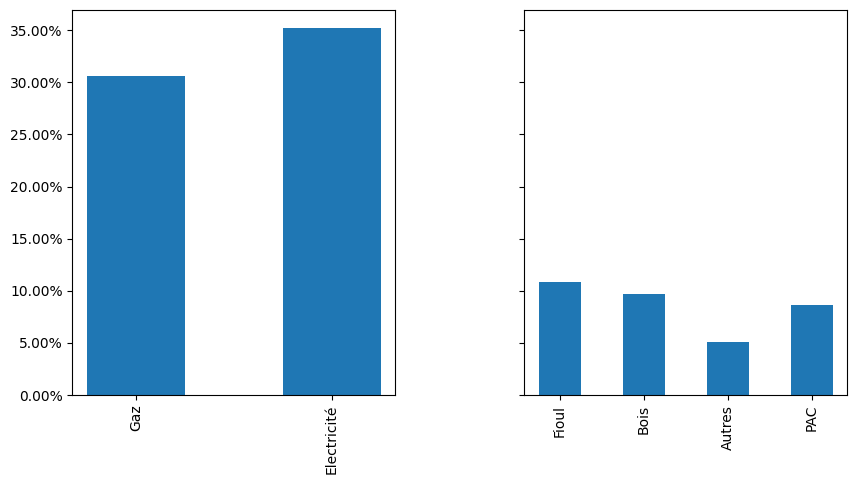

In [81]:
# show repartition
from lib.useful import get_dict

f, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
plt.subplots_adjust(wspace=0.4)
labels_over = {0: "Gaz", 1: "Electricité"}
labels_under = {0: "Fioul", 1: "Bois", 3: "Autres", 2: "PAC"}
all_labels = [labels_over, labels_under]
total = training_prod.count()
dfs = [training_prod_overclass, training_prod_subclass]
for i, (ax, labels, df) in enumerate(zip(axs.flatten(), all_labels, dfs)):
    values = get_dict(
        df.groupBy("heating_production").count().orderBy("heating_production")
    )

    percent = [value * 100 / total for value in values["count"]]
    x = values["heating_production"]
    min_value = int(min(values["heating_production"]))

    # bar graph
    bars = ax.bar(x=x, height=percent, width=0.5)
    ax.set_xticks(
        range(min_value, len(labels) + min_value), labels.values(), rotation=90
    )

    # set y ticks
    vals = ax.get_yticks()
    ax.set_yticklabels(["%1.2f%%" % i for i in vals])

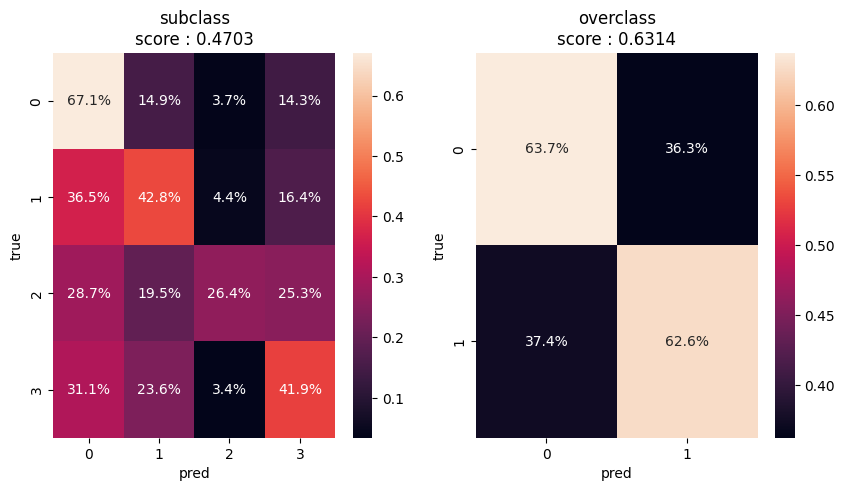

In [83]:
# global params
col_X_hot = [[]]
col_y = ["heating_production"]
col_X_not_hot = [
    [col[0] for col in training_prod.dtypes if col[0] not in col_X_hot[i] + col_y + ['index']]
    for i in range(len(col_X_hot))
]
hyperparams_models = [
    {
        "max_depth": randint(1, 20),
        "n_estimators": randint(50, 200),
        "class_weight": ["balanced"],
    }
]
models = {
    "RandomForestClassifier": RandomForestClassifier,
}

# cut dataset into train test valid
X_train_sub, y_train_sub, _ = prepare_dataset(
    training_prod_subclass.filter(
        F.col('index').isin(indexes_train.tolist())
    ).drop('index'),
    dictionary, col_X_hot[0], col_X_not_hot[0], col_y, False, True
)
X_valid_sub, y_valid_sub, _ = prepare_dataset(
    training_prod_subclass.filter(
        F.col('index').isin(valid_index)
    ).drop('index'),
    dictionary, col_X_hot[0], col_X_not_hot[0], col_y, False, True
)

X_train_over, y_train_over, _ = prepare_dataset(
    training_prod_overclass.filter(
        F.col('index').isin(indexes_train.tolist())
    ).drop('index'),
    dictionary, col_X_hot[0], col_X_not_hot[0], col_y, False, True
)
X_valid_over, y_valid_over, _ = prepare_dataset(
    training_prod_overclass.filter(
        F.col('index').isin(valid_index)
    ).drop('index'),
    dictionary, col_X_hot[0], col_X_not_hot[0], col_y, False, True
)

# find best hyperparams for the two cut datasets
best_model_sub, best_score_sub, best_params_sub, scores_sub = train_hyper(
                hyperparams_models[0],
                models["RandomForestClassifier"],
                X_train_sub,
                y_train_sub,
                4,
                42,
                [],
                0,
                'f1_micro',
            )


best_model_over, best_score_over, best_params_over, scores_over = train_hyper(
                hyperparams_models[0],
                models["RandomForestClassifier"],
                X_train_over,
                y_train_over,
                4,
                42,
                [],
                0,
                'f1_micro',
            )

y_pred_sub = best_model_sub.predict(X_valid_sub)
y_pred_over = best_model_over.predict(X_valid_over)
f, axs = plt.subplots(1,2, figsize=(10,5)) 
show_matrix(y_pred_sub, y_valid_sub, axs[0], 'subclass')
show_matrix(y_pred_over, y_valid_over, axs[1], 'overclass')

best_models_over = {"RandomForestClassifier" : [best_model_over]}
best_models_sub = {"RandomForestClassifier" : [best_model_sub]}

In [87]:
# stacking model with sklearn librairy
from sklearn.ensemble import StackingClassifier

estimators = [
    ("rf1", best_models_sub["RandomForestClassifier"][0]),
    ("rf2", best_models_over["RandomForestClassifier"][0]),
    ("lr", LR),
    ("RF", RF),
]

hyperparams_models = [
    {
        "max_iter": [1000],
        "C": [1, 50, 100, 500, 1000],
        "class_weight": ["balanced"],
    },
    {
        "max_depth": [2, 5, 7, 10],
        "n_estimators": [30, 50, 80, 100, 120],
        "class_weight": ["balanced"],
    },
    {
        "learning_rate": [0.001, 0.003, 0.003, 0.01],
        "n_estimators": [30, 50, 80, 100, 120],
    },
]
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": XGBClassifier,
}

# iterating over hyperparams
best = {}
for hyperparams, (model_name, model) in zip(hyperparams_models, models.items()):
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(cut_param) - 1 for cut_param in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)
    print(all_poss)

    parametrized_model = model(**current_params)
    stack = StackingClassifier(estimators, parametrized_model, cv="prefit")
    # register score
    stack.fit(X_train, y_train)
    score = f1_score(y_test, stack.predict(X_test), average="micro")
    max_score = deepcopy(score)
    best_params = deepcopy(current_params)
    best_model = deepcopy(stack)

    i = 0
    nb_print = (all_poss // 4) + 1
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        parametrized_model = model(**current_params)
        stack = StackingClassifier(estimators, parametrized_model, cv="prefit")
        # register score
        stack.fit(X_train, y_train)
        score = f1_score(y_test, stack.predict(X_test), average="micro")

        if score > max_score:
            max_score = deepcopy(score)
            best_params = deepcopy(current_params)
            best_model = deepcopy(stack)
    print(max_score, best_params)
    best[model_name] = {"model": best_model, "params": best_params, "score": score}

5
0 [0, 1, 0]
2 [0, 3, 0]
0.4498792270531401 {'max_iter': 1000, 'C': 1, 'class_weight': 'balanced'}
20
0 [1, 0, 0]
6 [3, 1, 0]
12 [1, 3, 0]
18 [3, 4, 0]
0.5398550724637681 {'max_depth': 5, 'n_estimators': 50, 'class_weight': 'balanced'}
20
0 [1, 0]
6 [3, 1]
12 [1, 3]
18 [3, 4]
0.428743961352657 {'learning_rate': 0.001, 'n_estimators': 100}


In [88]:
best_stacked_model = max(best.values(), key=lambda x: x["score"])["model"]
y_pred_stack = best_stacked_model.predict(X_valid)

RF : {'model': RandomForestClassifier(class_weight='balanced', max_depth=19, n_estimators=171), 'score': 0.4568862275449102}
RF_sampled : {'model': RandomForestClassifier(class_weight='balanced', max_depth=18, n_estimators=93), 'score': 0.41976047904191616, 'sm': SMOTE(k_neighbors=2, random_state=42,
      sampling_strategy={0: 3407, 1: 3000, 2: 2700, 3: 2000, 4: 2500, 5: 3916})}
satck RFover/RFsub sklearn : {'model': StackingClassifier(cv='prefit',
                   estimators=[('rf1',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=17,
                                                       n_estimators=108)),
                               ('rf2',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=8,
                                                       n_estimators=82)),
                      

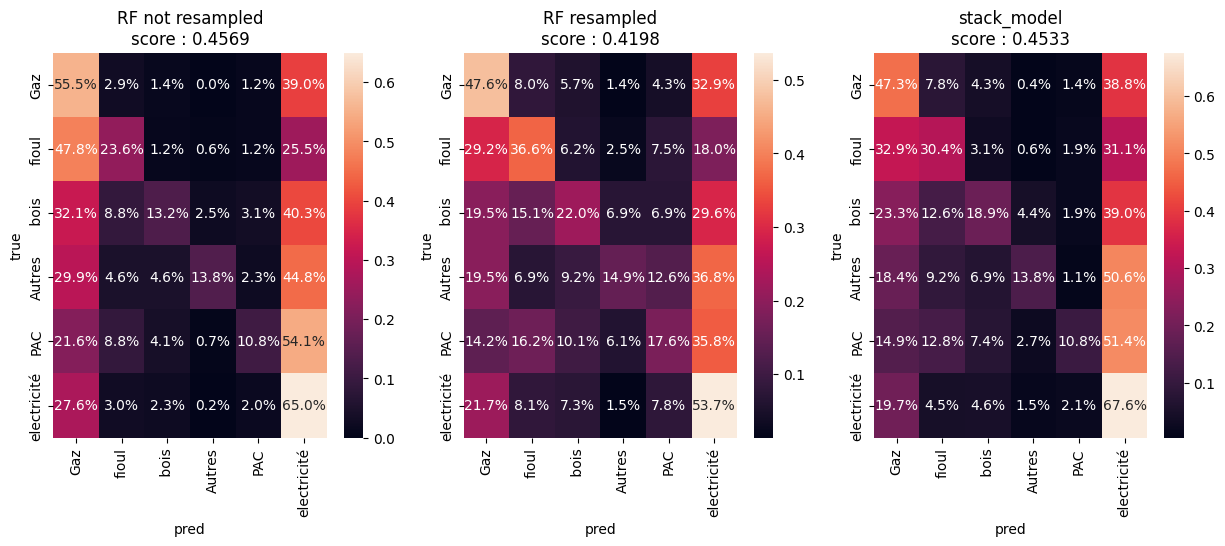

In [89]:
# compare every model
all_models = {
    "RF": {"model": RF, "score": f1_score(y_valid, y_pred, average="micro")},
    "RF_sampled": {
        "model": best_model_res,
        "score": f1_score(y_valid, y_pred_res, average="micro"),
        "sm": sm,
    },
    "satck RFover/RFsub sklearn": {
        "model": best_stacked_model,
        "score": f1_score(y_valid, y_pred_stack, average="micro"),
    },
}

for model_name, insights in all_models.items():
    print(f"{model_name} : {insights}")

labels = ["Gaz", "fioul", " bois", "Autres", "PAC", "electricité"]

f, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(hspace=0.35)
show_matrix(y_pred, y_valid, ax[0], f"RF not resampled", labels)
show_matrix(y_pred_res, y_valid, ax[1], f"RF resampled", labels)
show_matrix(y_pred_stack, y_valid, ax[2], f"stack_model", labels)